# Introduction and Overview

This notebook generates a sequence of six figures illustrating the flowchart steps in the Data Guide, specific
to biooptical sensors. We consider the triplet fluorometer installed at the Regional Cabled Array "Oregon Slope Base"
shallow profiler. The time range we consider is March 2021. To download the NetCDF data file, see the notebook
found within the ***Notebooks*** folder of this repository, titled **Ocean 05 A Programming Resources.ipynb**. 


The full resolution data file is about 610MB in size. It does not fit in this repository (limited by GitHub constraints)
so is placed in a parallel folder structure. 


This notebook makes use of a 'helper' Python module called `DataQualityGuideModule.py` located in this folder.
It is imported in the first Python cell below.


In what follows I am interspersing explanatory text cells to indicate 'what happens next' in the Python code.

In [1]:
# Set up this notebook to use code from an accompanying Python module file
from DataQualityGuideModule import *
print('\nJupyter running Python {}'.format(sys.version_info[0]))

OOI RCA Oregon Slope Base: Shallow Profiler status report
For March 2021:
31 days, translates to 279 possible profiles
Actual:
262 profiles; 29 at local midnight and 30 at local noon

Jupyter running Python 3


# Preparation


The data within file `flort_fullres.nc` are assigned to the XArray Dataset variable `D`. It is then
slightly modified 
and the contents are examined. 

In [3]:
# open the dataset (chlor-a, fdom/cdom and backscatter) as variable 'D'
D = xr.open_dataset('../data/rca/fluor/osb/2021/flort_fullres.nc')

# substitute time for 'observation number' as the primary dimension
D = D.swap_dims({'obs':'time'})

# diagnostic: how many data values present
print('Number of data values: after file is opened, before time range narrowed to March 2021: ', len(D.time))

# narrow the time range to March 2021 (31 days, 86400 seconds per day: 2678400 samples
D = D.sel(time=slice(dt64('2021-03-01'), dt64('2021-04-01')))

# diagnostic: Number of data values after time window applied
print("Number of data values: March 2021 only, compare to 'one per second' total of 2678400: ", len(D.time))

# drop NaN values
D = D.dropna('time')

# diagnostic: Number of data values: after dropping NaNs
print('D number of data values after dropping NaN values is the same: ', len(D.time))

# rename the three sensor data streams; easier to read
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})


# reference D to produce a printout of its structure in terms of dimensions, coordinates, data values and attributes
# Dimensions: time only
# Coordinates: five; but time and depth (for the profiler) are the important ones. 
# Data variables: 39 total; where the three fluorometer channels will be renamed in the following cell
# Attributes: 68 total; ancillary metadata such as fluormeter model and manufacturer
D

Number of data values: after file is opened, before time range narrowed to March 2021:  5830998
Number of data values: March 2021 only, compare to 'one per second' total of 2678400:  2231042
D number of data values after dropping NaN values is the same:  2231042


<xarray.Dataset>
Dimensions:                                          (time: 2231042)
Coordinates:
    obs                                              (time) int32 2627967 ......
    lon                                              (time) float64 ...
    lat                                              (time) float64 ...
    depth                                            (time) float64 ...
  * time                                             (time) datetime64[ns] 20...
Data variables: (12/39)
    practical_salinity                               (time) float64 33.87 ......
    fluorometric_chlorophyll_a_qc_results            (time) uint8 12 12 ... 12
    fdom                                             (time) float64 1.3 ... 1...
    signal_3_offset                                  (time) float32 0.0 ... 0.0
    fluorometric_cdom_qc_executed                    (time) uint8 29 29 ... 29
    measurement_wavelength_cdom                      (time) float32 460.0 ......
    ...                                               ...
    total_volume_scattering_coefficient              (time) float64 9.269e-05...
    signal_2_offset                                  (time) float32 0.0 ... 0.0
    chlora                                           (time) float64 -0.0107 ....
    raw_internal_temp                                (time) float32 549.0 ......
    backscatter                                      (time) float64 0.0006074...
    fluorometric_cdom_qc_results                     (time) uint8 29 29 ... 29
Attributes: (12/68)
    node:                               SF01A
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -125.3896636
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

### Remark on QC flags

OOI provides a [web guide to QC flags](https://oceanobservatories.org/knowledgebase/interpreting-qc-variables-and-results/)
to help with their interpretation. Below we examine the first qc flag value for `fluorometric_cdom_qc_executed`
This integer value (29) is interpreted as a series of binary flags (right to left) that tell which tests have been 
applied to the stream data.


In [6]:
# The very first 'cdom_qc_executed' flag in the dataset time series, in binary
bin(int(D.fluorometric_cdom_qc_executed[0]))

'0b11101'

Reading bits right to left: This indicates that tests 1, 3, 4 and 5 were completed. 
From the above web page these are respectively

```
1. global_range_test
2. dataqc_localrangetest: Not completed
3. dataqc_spiketest
4. dataqc_polytrendtest
5. dataqc_stuckvaluetest
6. dataqc_gradienttest: Not completed
```


As we will see, there are two extraneous data spikes in the FDOM/CDOM signal during March 2021. We would need to 
examine `fluorometric_cdom_qc_results` to see if these were picked up by the above qc tests. 

# Figure 1: Examine data

We begin with the simple plot function built into XArray DataArrays. The data time range was narrowed above to March 2021.
Some aberrant spikes are apparent in the FDOM (second chart).

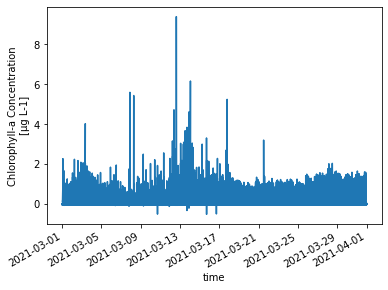

In [7]:
D.chlora.plot()

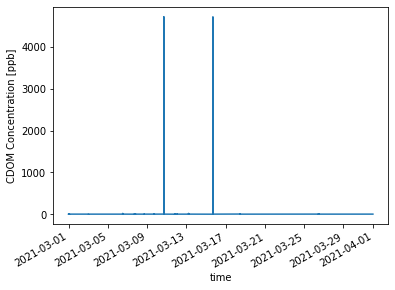

In [8]:
D.fdom.plot()

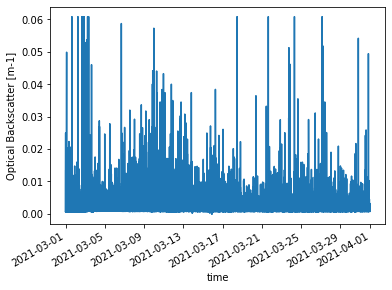

In [9]:
D.backscatter.plot()

As the FDOM spikes are clearly erroneous data, let's focus on the first of those two spikes. It occurs on March 10 2021.

March 10 number of data values:  71998  compared to 86400 sec/day


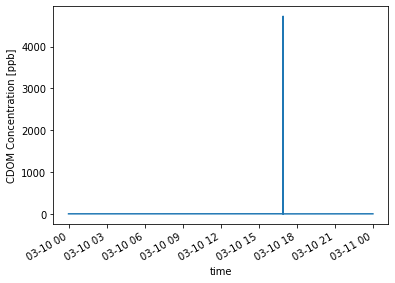

In [10]:
DMar10 = D.sel(time=slice(dt64('2021-03-10'), dt64('2021-03-11')))
print('March 10 number of data values: ', len(DMar10.time), ' compared to 86400 sec/day')
DMar10.fdom.plot()

In [11]:
DMar10.fluorometric_cdom_qc_results[0:5]

<xarray.DataArray 'fluorometric_cdom_qc_results' (time: 5)>
array([29, 29, 29, 29, 29], dtype=uint8)
Coordinates:
    obs      (time) int32 3275959 3275960 3275961 3275962 3275963
    lon      (time) float64 ...
    lat      (time) float64 ...
    depth    (time) float64 ...
  * time     (time) datetime64[ns] 2021-03-10T00:00:00.946225152 ... 2021-03-...

In [13]:
Dprime = DMar10.where(DMar10.fdom > 100., drop=True)
Dprime.fluorometric_cdom_qc_results[0:2]

<xarray.DataArray 'fluorometric_cdom_qc_results' (time: 2)>
array([28., 28.])
Coordinates:
    obs      (time) int32 3326690 3326691
    lon      (time) float64 -125.4 -125.4
    lat      (time) float64 44.53 44.53
    depth    (time) float64 5.993 5.571
  * time     (time) datetime64[ns] 2021-03-10T16:54:58.610949632 2021-03-10T1...

In [15]:
int(DMar10.obs[0])

3275959

In [16]:
3326690 - 3275959 

50731

In [17]:
DMar10.time[0]

<xarray.DataArray 'time' ()>
array('2021-03-10T00:00:00.946225152', dtype='datetime64[ns]')
Coordinates:
    obs      int32 3275959
    lon      float64 ...
    lat      float64 ...
    depth    float64 ...
    time     datetime64[ns] 2021-03-10T00:00:00.946225152
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

In [25]:
DMar10.fluorometric_cdom_qc_results[50728:50988]

<xarray.DataArray 'fluorometric_cdom_qc_results' (time: 260)>
array([29, 29, 28, ..., 29, 29, 29], dtype=uint8)
Coordinates:
    obs      (time) int32 3326687 3326688 3326689 ... 3326944 3326945 3326946
    lon      (time) float64 ...
    lat      (time) float64 ...
    depth    (time) float64 ...
  * time     (time) datetime64[ns] 2021-03-10T16:54:55.225200640 ... 2021-03-...

In [27]:
DMar10.fluorometric_cdom_qc_executed[50728:50738]

<xarray.DataArray 'fluorometric_cdom_qc_executed' (time: 10)>
array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29], dtype=uint8)
Coordinates:
    obs      (time) int32 3326687 3326688 3326689 ... 3326694 3326695 3326696
    lon      (time) float64 ...
    lat      (time) float64 ...
    depth    (time) float64 ...
  * time     (time) datetime64[ns] 2021-03-10T16:54:55.225200640 ... 2021-03-...

13 = 1101 so really 01101 so it is failing the 'stuck value test'. 

Really the 'upgrade' to this process would be to only keep data values where the `_qc_results` values
matched the `_qc_executed` values, in this case 29.

# Part 2: Manually correct or delete bad data


Note that the bad data exceed 4000; so we apply a simple conditional filter to remove any data with FDOM value in excess of 100.

In [ ]:
# Filter out data with FDOM values exceeding 100
DMar10 = DMar10.where(DMar10.fdom < 100., drop=True)
print('March 10 number of data values: ', len(DMar10.time), ' (2 spike values removed)')
DMar10.fdom.plot()

The scalloped appearance of this data is due to the nine daily ascent/descent cycles of the shallow profiler. It begins 
at a depth of about 200 meters and ascends to about 10 meters, then returns.

In [ ]:
# chlora data shows profile structure: variations in chlorophyll concentration with depth
DMar10.chlora.plot()

In [ ]:
# backscatter shows less obvious profile structure
DMar10.backscatter.plot()

Remark on sample timing: The 'observation' coordinate proceeds as a simple counter. The 'time' coordinate is a series of timestamps.
The chart below shows time versus observation number. It is quite regular. There are no jumps in continuity that
might indicate the fluorometer went offline for some time, for example.

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5), tight_layout=True)
axs.plot(DMar10.obs, DMar10.time, color='k')

# Figure 3: Examine data

# Figure 4: Examine data

# Figure 5: Examine data

# Figure 6: Examine data